In [1]:
import pandas as pd
import os
import shutil
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ====== Pre-process the data using DataProcessor ====== #
from data_processor import DataProcessor

# Initialize data processor
data_processor = DataProcessor("gender_unprocessed.csv", "gender_snps.csv")

# Run full pipeline
data_processor.load_data()
data_processor.remove_duplicates()
data_processor.define_snp_columns()
data_processor.standardize_phenotype(trait_col='biological_gender', new_col='biological_gender_standardized')
data_processor.standardize_genotypes()
data_processor.save_cleaned()

Sample size: 1022
Columns: ['user_num', 'ID-number', 'biological_gender', 'rs757619452', 'rs569336697', 'rs11575897', 'rs2534636']
Sample size after removing duplicates: 1021
SNP columns: ['rs757619452', 'rs569336697', 'rs11575897', 'rs2534636']
Standardized biological_gender values written to 'biological_gender_standardized'.
Genotypes standardized.
Unique values per SNP (showing up to 10):
rs757619452: ['NN' 'GG']
rs569336697: ['NN' 'TT' 'CC']
rs11575897: ['GG' 'NN' 'AA']
rs2534636: ['CC' 'NN' 'TT']
Standardized dataset saved to: G:\Other computers\My Laptop\Thesis_New\blood_type\gender_standardized.csv
Cleaned dataset saved to: gender_cleaned.csv


In [3]:
# ====== Standardization and Grouping ====== #
# Import genotype processor
from genotype_processor import GenotypeProcessor

# Load cleaned data
gender_cleaned = pd.read_csv('gender_cleaned.csv')
snp_cols = [col for col in gender_cleaned.columns if col.startswith('rs') or col.startswith('i')]

# Set up processor
genotype_processor = GenotypeProcessor(gender_cleaned,
                                       'biological_gender_standardized',
                                       snp_cols=snp_cols)

# Print unique populations based on "biological_gender" col.
genotype_processor.print_unique_traits('biological_gender_standardized')

Unique biological_gender_standardized: ['Male' 'Female' 'Man' 'Woman' 'Transgender ftm'
 'Female but feel non-gendered' 'Male but genderfluid' 'Transgender mtf'
 'Trans woman' 'Love it' 'Non-binary xx / genderqueer female-bodied'
 'Transgender intersex'],


In [4]:
# Remove rows with invalid gender reported
print(f'Number of rows before filtering: {len(gender_cleaned)}')
gender_cleaned = gender_cleaned[
    (gender_cleaned['biological_gender_standardized'] != 'Trans woman') & (gender_cleaned['biological_gender_standardized'] != 'Love it')
    & (gender_cleaned['biological_gender_standardized'] != 'Transgender intersex')]
print(f'Number of rows after filtering: {len(gender_cleaned)}')

# defines map for type standardization
gender_mapping = {
    'Biological Female': ['Female', 'Woman', 'Transgender ftm', 'Female but feel non-gendered', 'Non-binary xx / genderqueer female-bodied'],
    'Biological Male': ['Male', 'Man', 'Transgender mtf', 'Male but genderfluid', 'Transgender mtf']
    }

# Standardize types
gender_std = genotype_processor.standardize_traits(gender_mapping, 'biological_gender_standardized',
                                                      'Gender Standardized', gender_cleaned)
gender_std.to_csv('gender_std.csv', index=False)

# Print unique types after standardization
genotype_processor.print_unique_traits('Gender Standardized', gender_std)

Number of rows before filtering: 1021
Number of rows after filtering: 1007
Unique Gender Standardized: ['Biological Male' 'Biological Female'],


In [5]:
# Identify rows where biological_gender is "Biological Male" and all SNPs are "NN"
snp_cols = [col for col in gender_std.columns if col.startswith('rs') or col.startswith('i')]

male_missing_snps = gender_std[
    (gender_std['Gender Standardized'] == 'Biological Male') &
    (gender_std[snp_cols].apply(lambda row: all(val == 'NN' for val in row), axis=1))]

# Remove these rows from the dataset
gender_processed = gender_std.drop(male_missing_snps.index)

# Output the removed rows for verification (optional)
print("Removed Samples:")
print(len(male_missing_snps))

# Save the filtered dataset (optional)
gender_processed.to_csv('gender_processed.csv', index=False)

Removed Samples:
20


In [6]:
class_distribution = gender_processed['Gender Standardized'].value_counts()
print(f"Class Distribution {class_distribution}:")

Class Distribution Gender Standardized
Biological Male      517
Biological Female    470
Name: count, dtype: int64:



=== Gender Prediction Results ===
                   precision    recall  f1-score   support

Biological Female       1.00      0.98      0.99       470
  Biological Male       0.98      1.00      0.99       517

         accuracy                           0.99       987
        macro avg       0.99      0.99      0.99       987
     weighted avg       0.99      0.99      0.99       987

Accuracy: 0.992
Weighted F1 Score: 0.992
Predictions saved to: results\gender_gender_predictions.csv
Report saved to: results\gender_gender_classification_report.txt


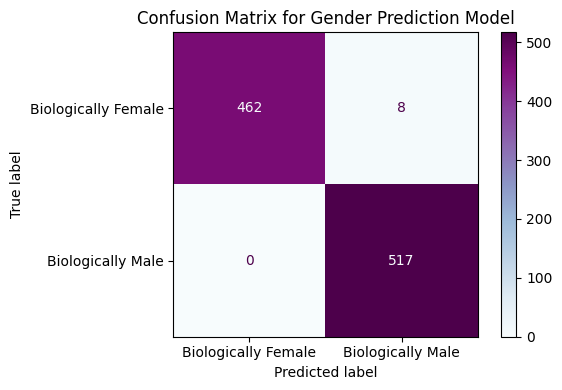

In [7]:
# ====== Gender Prediction ====== #
# Import trait classifier
from trait_classifier import TraitClassifier

# Load snps data
gender_snps = pd.read_csv('gender_snps.csv')

# Define X and y
X = gender_processed.drop(columns=['Gender Standardized'])
y = gender_processed['Gender Standardized']

# Initialize classifier
classifier = TraitClassifier(X, y, snp_cols)

# Predict gender and plot confusion matrix
classifier.gender_model(gender_processed, gender_snps,
                        trait_col='Gender Standardized',
                        new_col='predicted_gender',
                        export_csv=True,
                        folder='results',
                        prefix='gender')